In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from nvae_layers import SqueezeExciteLayer
from nvae_layers import FactorizedDownsample
from nvae_layers import ResidualDecoderCell
from nvae_layers import ResidualEncoderCell
from nvae_layers import CombinerSampler
from nvae_layers import NvaeConv2D
from nvae_model import  create_nvae
from dataset_utils import LfwDataset

print(f'Using Python={sys.version}')
print(f'Using Tensorflow={tf.__version__}')
print(f'Using Keras={tf.keras.__version__}')
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) == 0:
    print("No GPU(s) available")
else:
    print("GPU(s) Available: ") 
    for g in gpus:
        print('  ', g)

Using Python=3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
Using Tensorflow=2.3.0
Using Keras=2.4.0
GPU(s) Available: 
   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
%load_ext autoreload
%autoreload 2

In [22]:
IMAGE_SIZE=(64, 64, 3)
lfw = LfwDataset()

print('Loading a sample of the dataset to check sizes')
lfw.tfds_load(load_sample=True)
orig_shape = lfw.get_base_img_shape()
scalar = - orig_shape[-3] / IMAGE_SIZE[-3]

print()
print('Loading the full dataset, resampled/rescaled')
lfw.tfds_load(scale=scalar)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64

Loading a sample of the dataset to check sizes
Train samples: 32
Val samples:   32
Test samples:  32
Display test image shape: (32, 160, 160, 3)

Loading the full dataset, resampled/rescaled
Train samples: 10586
Val samples:   1324
Test samples:  1323
Display test image shape: (32, 64, 64, 3)


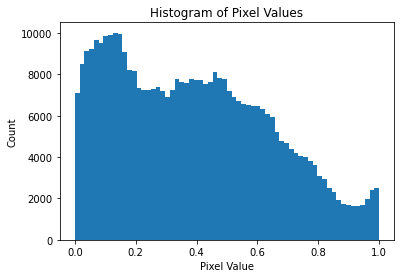

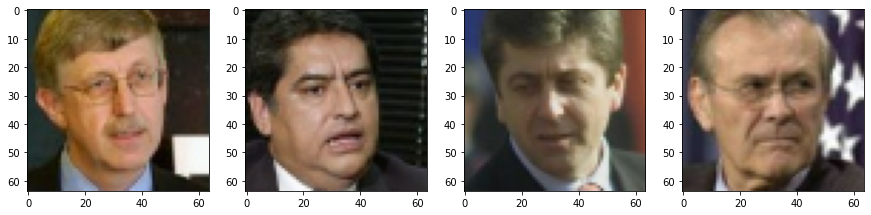

In [10]:
fig, ax = plt.subplots()
ax.hist(lfw.data_sample.reshape((-1,)), bins=64)
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Pixel Values')

fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    axs[i].imshow(lfw.data_sample[i])

In [11]:
x = inputs = L.Input(shape=IMAGE_SIZE)
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, downsample=True, scale_channels=2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, downsample=True, scale_channels=2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, upsample=True, scale_channels=-2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, upsample=True, scale_channels=-2)(x)
x = NvaeConv2D(kernel_size=1, abs_channels=3)(x)

test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()

Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
nvae_conv2d (NvaeConv2D)     (None, 64, 64, 32)        896       
_________________________________________________________________
nvae_conv2d_1 (NvaeConv2D)   (None, 64, 64, 32)        9248      
_________________________________________________________________
nvae_conv2d_2 (NvaeConv2D)   (None, 64, 64, 32)        9248      
______

In [12]:
print('Pass thru 8 images:', test_model(lfw.data_sample[:8]).shape)

Pass thru 8 images: (8, 64, 64, 3)


In [13]:
x = inputs = L.Input(shape=IMAGE_SIZE)
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell(downsample=True)(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell(downsample=True)(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell(upsample=True)(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell(upsample=True)(x)
x = NvaeConv2D(kernel_size=3, abs_channels=3)(x)
test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()

Spectral Norm is disabled!
ResEncCell build shape: (None, 64, 64, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 64, 64, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 64, 64, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
FactDown build shape: (None, 64, 64, 32)
ResEncCell build shape: (None, 32, 32, 64)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 32, 32, 64)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 32, 32, 64)
Spectral Norm is disabled!
Spectral Norm is disabled!
FactDown build shape: (None, 32, 32, 64)
ResDecCell build shape: (None, 16, 16, 128)
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
ResDecCell build shape: (None, 16, 16, 128)
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
ResDecCell build shape: (None, 16, 16, 128)
Spectral Norm i

In [73]:
x = inputs = L.Input(shape=(16, 16, 3))
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = left = ResidualEncoderCell(downsample=True)(x)
x = ResidualEncoderCell(downsample=True)(x)
x = right = ResidualDecoderCell(upsample=True)(x)
x = CombinerSampler()([left, right])

test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()


Spectral Norm is disabled!
ResEncCell build shape: (None, 16, 16, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
FactDown build shape: (None, 16, 16, 32)
ResEncCell build shape: (None, 8, 8, 64)
Spectral Norm is disabled!
Spectral Norm is disabled!
FactDown build shape: (None, 8, 8, 64)
ResDecCell build shape: (None, 4, 4, 128)
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
CombSample build shape: [TensorShape([None, 8, 8, 64]), TensorShape([None, 8, 8, 64])]
Spectral Norm is disabled!
Spectral Norm is disabled!
Spectral Norm is disabled!
Sampling build shape: [TensorShape([None, 8, 8, 64]), TensorShape([None, 8, 8, 64])]
Model: "functional_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 16, 16, 3)]  0                       

In [74]:
test_model(lfw.data_sample[:4, :16, :16, :], training=True).shape

TensorShape([4, 8, 8, 64])

In [120]:
full_model = create_nvae(
    input_shape=(160, 160, 3),
    base_num_channels=16,
    nscales=2,
    ngroups=2,
    ncells=2,
    nlatent=20,
    num_prepost_blocks=1,
    num_prepost_cells=2)

print('Full model output shape:', full_model(lfw.data_sample[:4, :, :, :], training=False).shape)
print('Full model output shape:', full_model(lfw.data_sample[:4, :, :, :], training=True).shape)

Spectral Norm is disabled!
ResEncCell build shape: (None, 160, 160, 16)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 160, 160, 16)
Spectral Norm is disabled!
Spectral Norm is disabled!
FactDown build shape: (None, 160, 160, 16)
ResEncCell build shape: (None, 80, 80, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 80, 80, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 80, 80, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 80, 80, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 80, 80, 32)
Spectral Norm is disabled!
Spectral Norm is disabled!
FactDown build shape: (None, 80, 80, 32)
ResEncCell build shape: (None, 40, 40, 64)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell build shape: (None, 40, 40, 64)
Spectral Norm is disabled!
Spectral Norm is disabled!
ResEncCell b

In [121]:
full_model.summary()

Model: "functional_86"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
pre_stem (NvaeConv2D)           (None, 160, 160, 16) 448         input_49[0][0]                   
__________________________________________________________________________________________________
pre_blk0_c0 (ResidualEncoderCel (None, 160, 160, 16) 4916        pre_stem[0][0]                   
__________________________________________________________________________________________________
pre_blk0_c1 (ResidualEncoderCel (None, 80, 80, 32)   14916       pre_blk0_c0[0][0]                
______________________________________________________________________________________

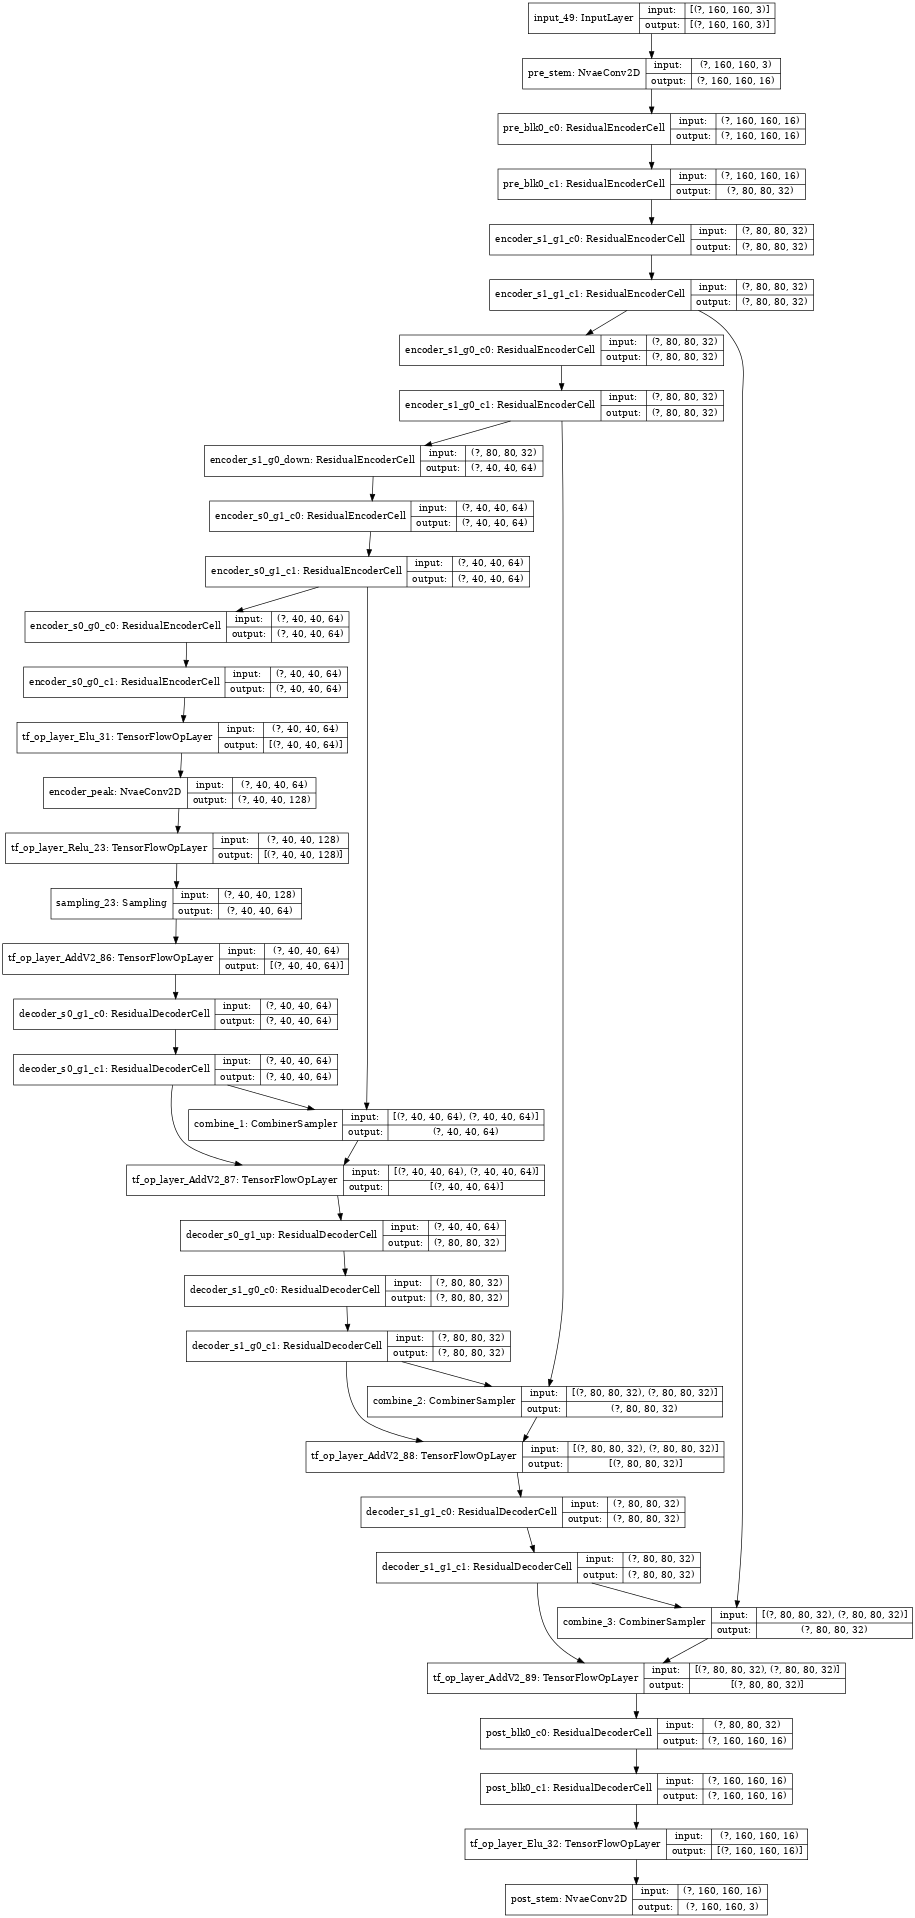

In [123]:
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True, dpi=48)
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True, dpi=48, to_file='small_nvae.png')

In [ ]:
INITIAL_LR = 1e-4
opt = tf.keras.optimizers.Adamax(INITIAL_LR)
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1)
cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
cb_chkpoint = tf.keras.callbacks.ModelCheckpoint('best_vae', monitor='val_loss', save_best_only=True, save_weights_only=True)

IMAGE_SIZE = (160, 160, 3)
full_nvae = create_nvae(
    input_shape=(160, 160, 3),
    base_num_channels=16,
    nscales=2,
    ngroups=2,
    ncells=2,
    nlatent=20,
    num_prepost_blocks=1,
    num_prepost_cells=2)

test_out = full_nvae(tf.zeros((1,) + IMAGE_SIZE))
opt = tf.keras.optimizers.RMSprop(INITIAL_LR, clipnorm=100)
vae_submodel.compile(opt, loss='mse', metrics='mse')
hist = vae_submodel.fit(
    train_ds_xx,
    validation_data=val_ds_xx,
    epochs=150,
    callbacks=[cb_chkpoint, cb_earlystop, cb_reducelr])


vae_submodel.load_weights('best_vae')
model_parts.save_all_models(prefix='vae_pretrained')

In [20]:
test_input = cexpand(lfw.data_sample[:8])
test_nfilt = 32
#rdc = ResidualDecoderCell(expand_ratio=4, se_ratio=8, bn_momentum=0.9, gamma_reg=None)
cexpand = L.Conv2D(filters=test_nfilt, kernel_size=1, strides=1, padding='same')
test_input = cexpand(lfw.data_sample[:8])

rdc(test_input, training=True)
rdc(test_input, training=False)
print(test_input.shape)
dmodel = rdc.build(test_input.shape)
dmodel = rdc.create_model(test_input.shape[1:])
dmodel.summary()

ResDecCell build shape: (8, 160, 160, 32)
(8, 160, 160, 32)
ResDecCell build shape: (8, 160, 160, 32)


AttributeError: 'ResidualDecoderCell' object has no attribute 'conv_depth2'

In [ ]:
tf.keras.utils.plot_model(dmodel, show_shapes=True, dpi=48)

In [ ]:

rec = ResidualEncoderCell(se_ratio=8)
test_nfilt = 32
rec(test_input).shape
emodel = rec.create_model(test_input.shape[1:])
emodel.summary()

In [ ]:
tf.keras.utils.plot_model(emodel, show_shapes=True, dpi=48)